# Vibration features visualization

In [1]:
# Import
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
import os
import csv
from python_speech_features import mfcc
from python_speech_features import logfbank
plt.style.use('dark_background')

In [2]:
# Get the root path of the project
#ROOT_DIR = os.path.relpath("../../07_Measure/Outdoor_200924")
ROOT_DIR = os.path.relpath("C:/Temp/MeasureVibDone")
os.chdir(ROOT_DIR)
print(os.getcwd())

C:\Temp\MeasureVibDone


In [3]:
'''
Function : getDataFromFile
Param    : path to file
Return   : data_np -> Numpy array with all data (3 acc x 3 axis)
           hpfEnable -> return if the High Pass Filter was enabled during the measure
           FlowRate -> return the flow rate measured during the test
'''
def getDataFromFile(path):
    data = pd.read_csv(path, index_col=False , sep=';', skiprows=1, header=None, decimal=',')
    data_np = np.array(data, np.float64)

    with open(path) as csvFile:
        reader = csv.reader(csvFile, delimiter=';')
        field_names_list = next(reader)
        #print(field_names_list)
        hpfEnable = False
        flowRate = field_names_list[1]
    
    return data_np, hpfEnable, flowRate

In [4]:
'''
Function : plotDataset
Param    : Dataset to display
Return   : None
'''
def plotDataset(dataset):
        plot_acc1 = dataset.loc['Acc1']
        plot_acc2 = dataset.loc['Acc2']
        plot_acc3 = dataset.loc['Acc3']
        column = dataset.columns.values[i]
        plt.plot(plot_acc1['FlowRate'], plot_acc1[column], 'ro',
                 plot_acc2['FlowRate'], plot_acc2[column], 'bs',
                 plot_acc3['FlowRate'], plot_acc3[column], 'g^')
        plt.legend(['Acc1', 'Acc2', 'Acc3'])
        plt.title(dataset.columns.values[i])
        plt.xlabel('FlowRate', fontsize=15)
        plt.xticks(rotation=90)
        plt.ylabel('Value', fontsize=15)
        plt.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
        plt.show()

In [5]:
'''
Function : export FFT
Param    : data to convert + flowRate
Return   : Features
'''
def exportFFT(data, flowRate):
    acc1 = data[0,:]
    acc2 = data[1,:]
    acc3 = data[2,:]
    # Frequency informations
    acc1_fft = np.fft.rfft(acc1)
    acc2_fft = np.fft.rfft(acc2)
    acc3_fft = np.fft.rfft(acc3)
    # Compute the module of complexes numbers
    
    acc1_Norm = np.sqrt(np.power(acc1_fft.real,2)+np.power(acc1_fft.imag,2))
    acc2_Norm = np.sqrt(np.power(acc2_fft.real,2)+np.power(acc2_fft.imag,2))
    acc3_Norm = np.sqrt(np.power(acc3_fft.real,2)+np.power(acc3_fft.imag,2))
    acc1_Freq = np.fft.rfftfreq(len(acc1),d=1/120000)
    acc2_Freq = np.fft.rfftfreq(len(acc2),d=1/120000)
    acc3_Freq = np.fft.rfftfreq(len(acc3),d=1/120000)
    acc1_Freq = acc1_Freq[acc1_Freq <= 1000]
    acc2_Freq = acc2_Freq[acc2_Freq <= 1000]
    acc3_Freq = acc3_Freq[acc3_Freq <= 1000]
    acc1_Norm = acc1_Norm[:len(acc1_Freq)]
    acc2_Norm = acc2_Norm[:len(acc2_Freq)]
    acc3_Norm = acc3_Norm[:len(acc3_Freq)]
    
    acc1_feat = pd.concat([pd.DataFrame([flowRate]),
                           pd.DataFrame(acc1_Norm), 
                           pd.DataFrame(acc1_Freq)], axis=1, sort=False)
    acc2_feat = pd.concat([pd.DataFrame([flowRate]),
                           pd.DataFrame(acc2_Norm), 
                           pd.DataFrame(acc2_Freq)], axis=1, sort=False)
    acc3_feat = pd.concat([pd.DataFrame([flowRate]),
                           pd.DataFrame(acc3_Norm), 
                           pd.DataFrame(acc3_Freq)], axis=1, sort=False)
    return acc1_feat, acc2_feat, acc3_feat


In [6]:
'''
    Export FFT DATA from file in another file
'''
directory = "Meas_201008_WithFlowRate/"
list_meas_1 = os.listdir(directory)
all_peaks = pd.DataFrame()

samples = 60000

for file in list_meas_1:
# Retrieve data from file
    data_np, hpfEnable, flowRate = getDataFromFile(directory+file)   
    print("Flow Rate = ", flowRate)
    '''
    fig, (acc1_x, acc1_y, acc1_z) = plt.subplots(3, 1)
    fig.suptitle("Vib data")
    acc1_x.plot(data_np[0,:])
    acc1_y.plot(data_np[1,:])
    acc1_z.plot(data_np[2,:])
    plt.show()
    '''
    step = int(data_np[0,:].shape[0]/samples)
    cutsize = step * samples
    # Split the given data in multiple samples
    data_split = np.hsplit(data_np[:,:cutsize], step)
    index = 0
    for arr in data_split:
        fft1, fft2, fft3 = exportFFT(data_np, flowRate)
        fft1.to_csv('fft_'+ str(index) +'_'+ str(flowRate) + '.csv', sep=';')
        index = index + 1
        fft2.to_csv('fft_'+ str(index) +'_'+ str(flowRate) + '.csv', sep=';')
        index = index + 1
        fft3.to_csv('fft_'+ str(index) +'_'+ str(flowRate) + '.csv', sep=';')
        index = index + 1
    #fft.to_csv('fft_'+file, sep=';')
    #plotDataset(data_np)

Flow Rate =  0,000000
Flow Rate =  0,700000
Flow Rate =  3,200000
Flow Rate =  5,800000
Flow Rate =  7,100000
Flow Rate =  9,600000
Flow Rate =  12,800000
Flow Rate =  16,400000
Flow Rate =  21,600000
Flow Rate =  22,600000
Flow Rate =  24,100000
Flow Rate =  26,100000
Flow Rate =  27,900000
Flow Rate =  30,200000
Flow Rate =  33,100000
Flow Rate =  37,800000
Flow Rate =  41,400000


In [9]:
'''
    Get a window according to min/max
'''
def getWindow(sig_x, sig_y, min_x, max_x):
    condition = (sig_x < max_x) & (sig_x > min_x)
    trunc_y = sig_y[np.where(condition)]
    trunc_x = sig_x[np.where(condition)]
    
    return trunc_x, trunc_y

In [10]:
'''
    Display features
'''
def displayFeat(feat, name, x_axis):
    plt.title(name)
    plt.plot(x_axis,feat, 'g')
    plt.xlabel('Flow Rate [l/min]', fontsize=15)
    #plt.xlabel('Speed [m/s]', fontsize=15)
    plt.xticks(rotation=90)
    plt.ylabel('Magnitude '+name, fontsize=15)
    plt.show()

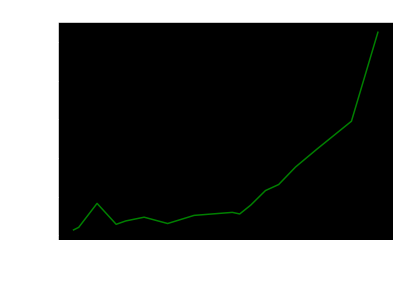

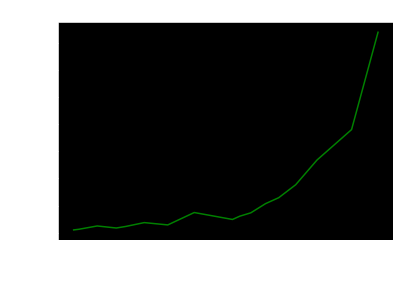

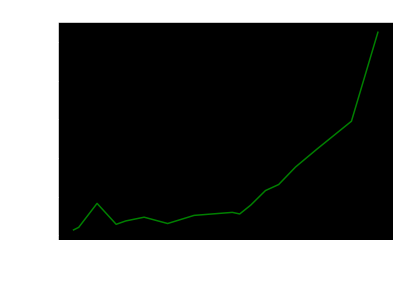

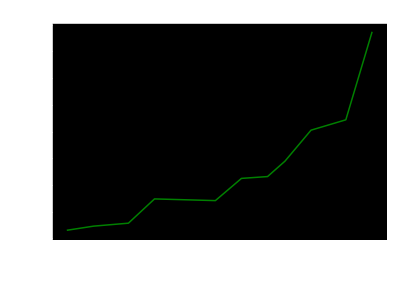

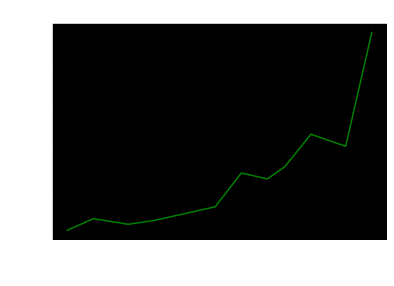

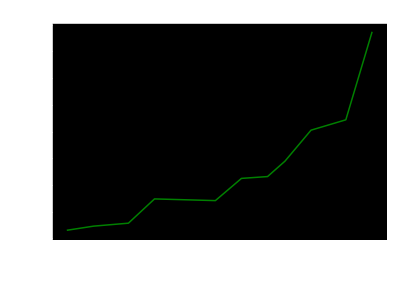

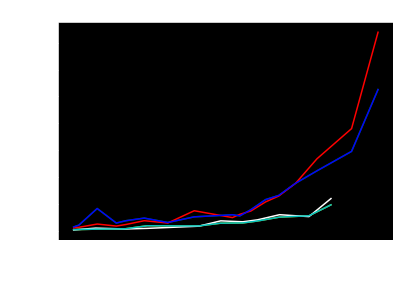

In [11]:
'''
    Display Features from FFT Data
'''
DIAMETER = 2 #cm

def getFeatures(directory, vib_no, isFlowRate=True, limit=[60,80]):
    list_meas_1 = os.listdir(directory)
    all_peaks = pd.DataFrame()
    feat_min = []
    feat_max = []
    feat_mean = []
    feat_rms = []
    feat_stddev = []
    speed = []

    for file in list_meas_1:
        data = pd.read_csv(directory+file, index_col=False , sep=';', skiprows=1, header=None, decimal='.')
        if isFlowRate:
            flowRate = float(data[1].iloc[0].replace(',','.'))
            data = data.drop(columns=[1])
        data_np = np.array(data, np.float64)[:len(data)-1,:] # Remove the NaN
        if vib_no == 1:
            trunc_x, trunc_y = getWindow(data_np[:,2], data_np[:,1], limit[0], limit[1])
        if vib_no == 2:
            trunc_x, trunc_y = getWindow(data_np[:,4], data_np[:,3], limit[0], limit[1])
        else:
            trunc_x, trunc_y = getWindow(data_np[:,6], data_np[:,5], limit[0], limit[1])
        if isFlowRate:
            area = np.pi * np.power((DIAMETER/100/2),2)
            n_speed = (flowRate / (1000*60)) / area
            speed = np.append(speed, n_speed)    
        feat_min = np.append(feat_min, trunc_y.min())
        feat_max = np.append(feat_max, trunc_y.max())
        feat_mean = np.append(feat_mean, trunc_y.mean())
        feat_rms = np.append(feat_rms, np.sqrt(sum(pow(trunc_y, 2)) / len(trunc_y)))
        feat_stddev = np.append(feat_stddev, np.sqrt(sum(pow(trunc_y - trunc_y.mean(), 2)) / len(trunc_y)))
        
    return feat_min, feat_max, feat_mean, feat_rms, feat_stddev, speed
    
_ , _ , _, feat_rms1, _, speed = getFeatures("FFT_Meas_201008/", 1, True, [70,100])
displayFeat(feat_rms1, 'rms', speed)
_ , _ , _, feat_rms2, _, speed = getFeatures("FFT_Meas_201008/", 2, True, [70,100])
displayFeat(feat_rms2, 'rms', speed)
_ , _ , _, feat_rms3, _, speed = getFeatures("FFT_Meas_201008/", 3, True, [70,100])
displayFeat(feat_rms3, 'rms', speed)

flowRate = np.array([0.0, 3.0, 7.0, 10.0, 17.0, 20.0, 23.0, 25.0, 28.0, 32.0, 35.0])
area = np.pi * np.power((DIAMETER/100/2),2)
speed2 = (flowRate / (1000*60)) / area

_ , _ , _, feat_rms4, _, _ = getFeatures("FFT_Meas_201005/", 1, False, [60,90])
displayFeat(feat_rms4, 'RMS', flowRate)
_ , _ , _, feat_rms5, _, _ = getFeatures("FFT_Meas_201005/", 2, False, [60,90])
displayFeat(feat_rms5, 'RMS', flowRate)
_ , _ , _, feat_rms6, _, _ = getFeatures("FFT_Meas_201005/", 3, False, [60,90])
displayFeat(feat_rms6, 'RMS', flowRate)

plt.title('asdf')
plt.plot(speed,feat_rms1, 'g')
plt.plot(speed,feat_rms2, 'r')
plt.plot(speed,feat_rms3, 'b')
plt.plot(speed2,feat_rms4, 'y')
plt.plot(speed2,feat_rms5, 'w')
plt.plot(speed2,feat_rms6, 'c')
plt.xlabel('Speed [m/s]', fontsize=15)
plt.xticks(rotation=90)
plt.ylabel('Magnitude RMS', fontsize=15)
plt.show()

In [ ]:
directory = "FFT_201008_WithFlowRate/"
IS_FLOWRATE = True
list_meas_1 = os.listdir(directory)

for file in list_meas_1:
    data = pd.read_csv(directory+file, index_col=False , sep=';', skiprows=1, header=None, decimal='.')
    if IS_FLOWRATE:
        flowRate = float(data[1].iloc[0].replace(',','.'))
        data = data.drop(columns=[1])
    data_np = np.array(data, np.float64)[:len(data)-1,:] # Remove the NaN
    min_d = 65
    max_d = 100
    trunc_x, trunc_y = getWindow(data_np[:,2], data_np[:,1], min_d, max_d)

    amp_x, _ = find_peaks(trunc_y, distance=5, threshold=1)
    amp_y = trunc_y[amp_x]
    amp_x = amp_x * (max_d - min_d) / max(amp_x) + min_d
    plt.title("FFT Flow Rate = " + str(flowRate) + "[l/min]")
    plt.plot(trunc_x, trunc_y, 'r')
    plt.plot(amp_x,amp_y, 'b')
    plt.xlabel('Frequency [Hz]', fontsize=15)
    plt.ylabel('Power', fontsize=15)
    plt.show()